In [81]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
import pandas as pd
import plotly.express as px

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = True

In [82]:
df = pd.read_csv("https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv")

In [83]:
df.head()
## every 30 min data # taxis active in interval of 3 0 min

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [84]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [85]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  10320 non-null  datetime64[ns]
 1   value      10320 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 161.4 KB


(10320, 2)

In [86]:
df1= df.set_index('timestamp').resample('D').mean()

In [87]:
df1.index.unique()

DatetimeIndex(['2014-07-01', '2014-07-02', '2014-07-03', '2014-07-04',
               '2014-07-05', '2014-07-06', '2014-07-07', '2014-07-08',
               '2014-07-09', '2014-07-10',
               ...
               '2015-01-22', '2015-01-23', '2015-01-24', '2015-01-25',
               '2015-01-26', '2015-01-27', '2015-01-28', '2015-01-29',
               '2015-01-30', '2015-01-31'],
              dtype='datetime64[ns]', name='timestamp', length=215, freq='D')

In [88]:
fig = px.line(df1.reset_index(), x= 'timestamp',y ='value', title= 'NYC Taxi demand')


fig.update_xaxes(
rangeslider_visible = True,
rangeselector = dict(
 buttons = list(
  [
      dict(count = 1, label = '1Y', step = 'year', stepmode='backward'),
      dict(count = 2, label = '2Y',step = 'year', stepmode = 'backward')
  ]   
 )
)
)
fig.show()

In [89]:
from prophet import Prophet

In [90]:
taxi_df = df.reset_index()[['timestamp','value']].rename({'timestamp':'ds', 'value':'y'}, axis = 'columns')

In [91]:
taxi_df

,ds,y
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820
...,...,...
10315,2015-01-31 21:30:00,24670
10316,2015-01-31 22:00:00,25721
10317,2015-01-31 22:30:00,27309
10318,2015-01-31 23:00:00,26591


In [92]:
train = taxi_df[(taxi_df['ds'] >= '2014-07-01') & (taxi_df['ds'] < '2014-12-31')]

In [93]:
test = taxi_df[taxi_df['ds'] > '2014-12-31']

In [94]:
train.shape, test.shape

((8784, 2), (1535, 2))

In [95]:
m = Prophet(changepoint_range = 0.95)

In [96]:
m.fit(train)

18:22:16 - cmdstanpy - INFO - Chain [1] start processing
18:22:18 - cmdstanpy - INFO - Chain [1] done processing


In [97]:
future = m.make_future_dataframe(31)
#predict for nxt 7 days

In [98]:
future.tail()

,ds
8810,2015-01-26 23:30:00
8811,2015-01-27 23:30:00
8812,2015-01-28 23:30:00
8813,2015-01-29 23:30:00
8814,2015-01-30 23:30:00


In [99]:
df.tail()

,timestamp,value
10315,2015-01-31 21:30:00,24670
10316,2015-01-31 22:00:00,25721
10317,2015-01-31 22:30:00,27309
10318,2015-01-31 23:00:00,26591
10319,2015-01-31 23:30:00,26288


In [100]:
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
8810,2015-01-26 23:30:00,5728.883618,610.542984,10719.593656
8811,2015-01-27 23:30:00,6421.485660,1835.207617,11777.068253
8812,2015-01-28 23:30:00,6448.287936,1389.940928,11211.882619
8813,2015-01-29 23:30:00,6539.529386,1519.634848,11276.033138
8814,2015-01-30 23:30:00,7615.347814,2264.175573,12031.585992


In [101]:
results = pd.concat([taxi_df.set_index('ds')['y'], forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']]],axis =1 )

In [102]:
results.head()

,y,yhat,yhat_lower,yhat_upper
ds,,,,
2014-07-01 00:00:00,10844,13376.182915,9048.911310,18213.413130
2014-07-01 00:30:00,8127,11997.665459,7410.892118,16820.129142
2014-07-01 01:00:00,6210,10447.792285,6119.720546,15322.685167
2014-07-01 01:30:00,4656,8717.014013,4126.761647,13221.745201
2014-07-01 02:00:00,3820,6858.642421,2155.968990,11440.904317


c:\Users\thaku\Downloads\m23\ann_class_pro\annenv\Lib\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\thaku\Downloads\m23\ann_class_pro\annenv\Lib\site-packages\prophet\plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



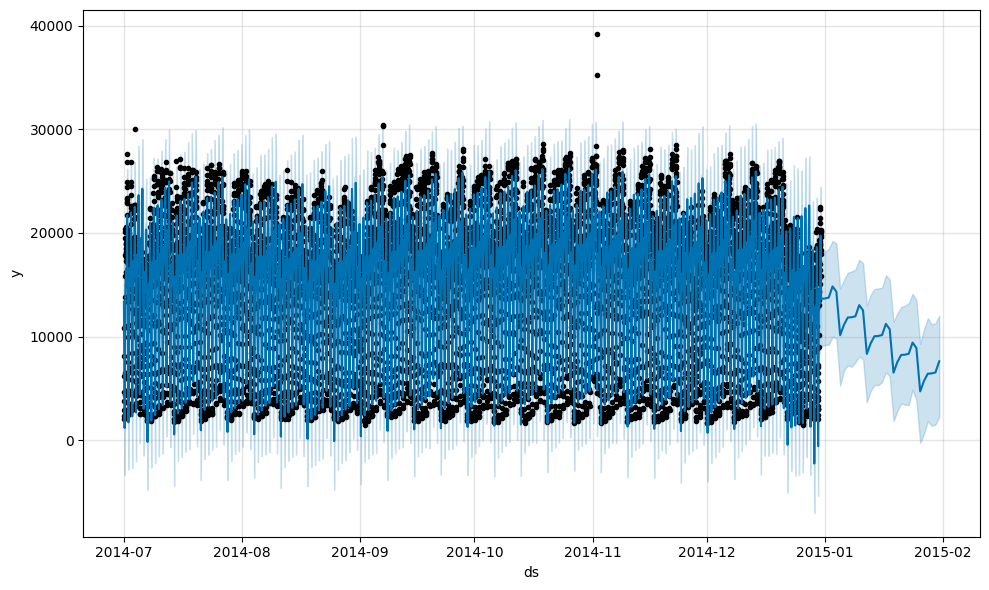

In [103]:
fig1 = m.plot(forecast)

In [104]:
## yhat_lower and upper are 95 percent CI

c:\Users\thaku\Downloads\m23\ann_class_pro\annenv\Lib\site-packages\prophet\plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\thaku\Downloads\m23\ann_class_pro\annenv\Lib\site-packages\prophet\plot.py:397: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\thaku\Downloads\m23\ann_class_pro\annenv\Lib\site-packages\prophet\plot.py:401: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\U

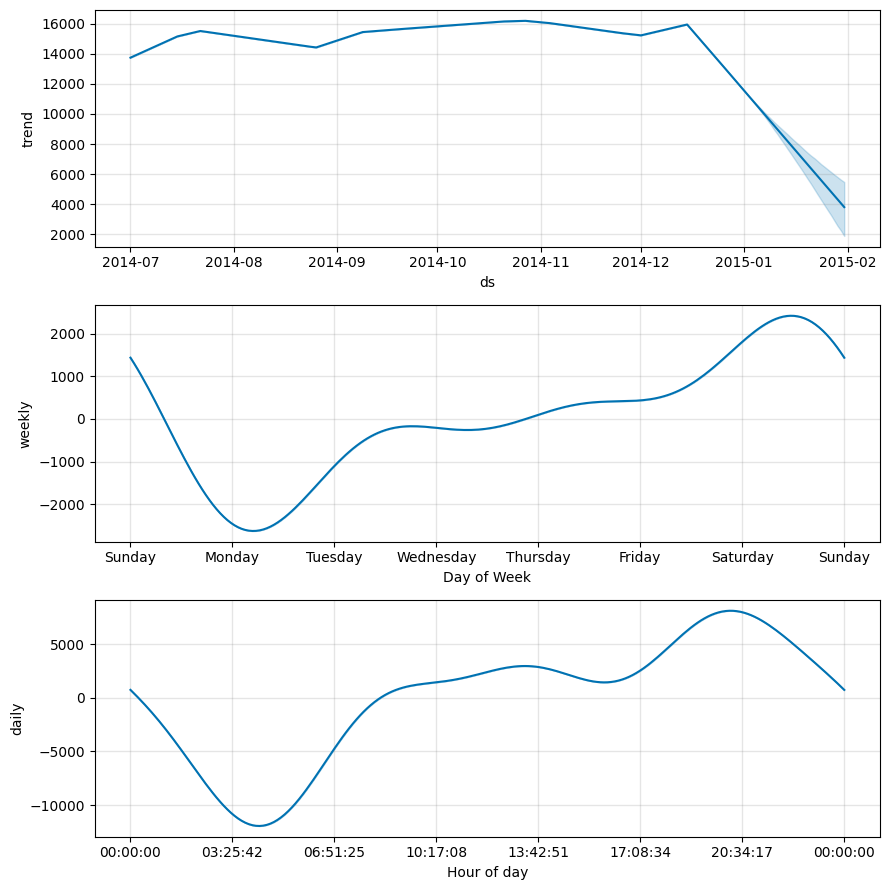

In [105]:
comp = m.plot_components(forecast)

In [106]:
results

,y,yhat,yhat_lower,yhat_upper
ds,,,,
2014-07-01 00:00:00,10844,13376.182915,9048.911310,18213.413130
2014-07-01 00:30:00,8127,11997.665459,7410.892118,16820.129142
2014-07-01 01:00:00,6210,10447.792285,6119.720546,15322.685167
2014-07-01 01:30:00,4656,8717.014013,4126.761647,13221.745201
2014-07-01 02:00:00,3820,6858.642421,2155.968990,11440.904317
...,...,...,...,...
2015-01-31 21:30:00,24670,NaN,NaN,NaN
2015-01-31 22:00:00,25721,NaN,NaN,NaN
2015-01-31 22:30:00,27309,NaN,NaN,NaN


In [107]:
results['error'] = results['y'] - results['yhat']

In [108]:
results['uncertainty'] = results['yhat_upper'] - results['yhat_lower']

In [109]:
results

,y,yhat,yhat_lower,yhat_upper,error,uncertainty
ds,,,,,,
2014-07-01 00:00:00,10844,13376.182915,9048.911310,18213.413130,-2532.182915,9164.501820
2014-07-01 00:30:00,8127,11997.665459,7410.892118,16820.129142,-3870.665459,9409.237023
2014-07-01 01:00:00,6210,10447.792285,6119.720546,15322.685167,-4237.792285,9202.964622
2014-07-01 01:30:00,4656,8717.014013,4126.761647,13221.745201,-4061.014013,9094.983554
2014-07-01 02:00:00,3820,6858.642421,2155.968990,11440.904317,-3038.642421,9284.935327
...,...,...,...,...,...,...
2015-01-31 21:30:00,24670,NaN,NaN,NaN,NaN,NaN
2015-01-31 22:00:00,25721,NaN,NaN,NaN,NaN,NaN
2015-01-31 22:30:00,27309,NaN,NaN,NaN,NaN,NaN


In [110]:
### checking outliers

In [111]:
results[results['error'].abs() > 1.5*results['uncertainty']]

,y,yhat,yhat_lower,yhat_upper,error,uncertainty
ds,,,,,,
2014-11-02 01:00:00,39197,15058.164367,10489.467944,19882.592415,24138.835633,9393.124471
2014-11-02 01:30:00,35212,13193.593487,8579.036467,17801.627608,22018.406513,9222.591141
2015-01-10 23:30:00,28401,12523.690066,7834.455183,17072.799680,15877.309934,9238.344497
2015-01-16 23:30:00,25472,11228.545724,6552.360633,15918.458613,14243.454276,9366.097979
2015-01-17 23:30:00,25251,10717.091112,6180.763255,15503.277066,14533.908888,9322.513811
2015-01-23 23:30:00,24597,9421.946769,4893.356397,14128.788742,15175.053231,9235.432346
2015-01-24 23:30:00,25928,8910.492157,3849.566495,13529.434414,17017.507843,9679.867919
2015-01-30 23:30:00,26000,7615.347814,2264.175573,12031.585992,18384.652186,9767.410420


In [120]:
## no fromula 1.5 dervied from knowledge of data should be tweeked around for bettter understandings

In [113]:
results['anomaly'] = results.apply(lambda x:'Yes' if(np.abs(x['error']) > 1.5 * x['uncertainty']) else 'no' , axis =1 )

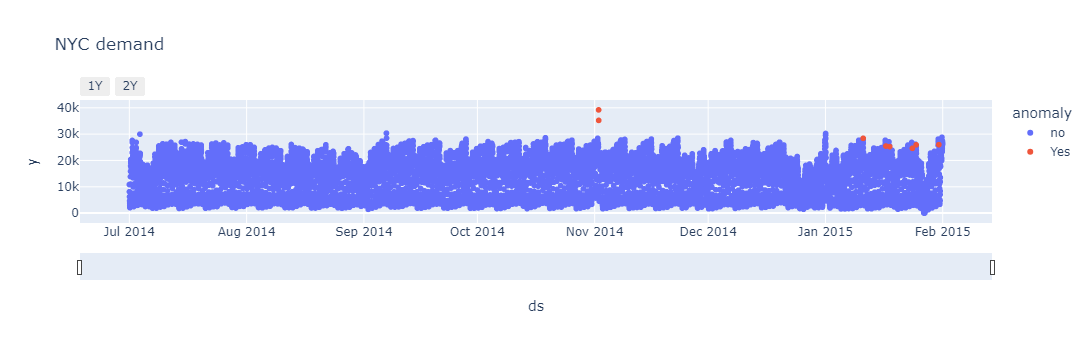

In [117]:
fig = px.scatter(results.reset_index(), x = 'ds', y ='y', color = 'anomaly', title = 'NYC demand')
fig.update_xaxes(
rangeslider_visible = True,
rangeselector = dict(
 buttons = list(
  [
      dict(count = 1, label = '1Y', step = 'year', stepmode='backward'),
      dict(count = 2, label = '2Y',step = 'year', stepmode = 'backward')
  ]   
 )
)
)
fig.show()

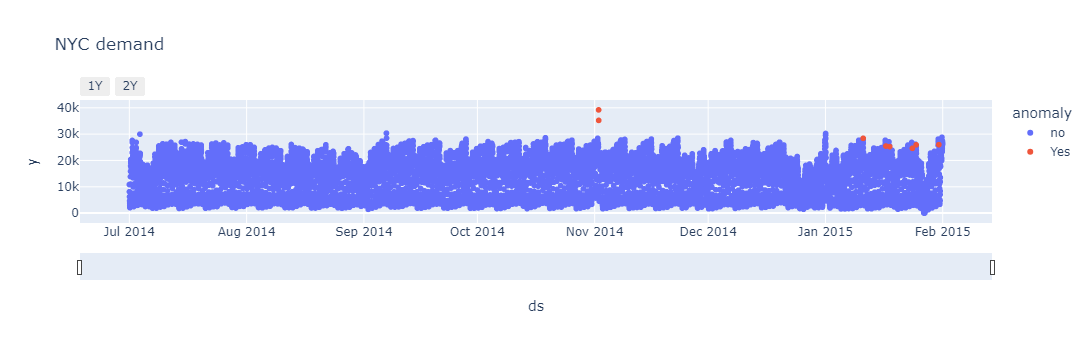

In [118]:
fig.show()

c:\Users\thaku\Downloads\m23\ann_class_pro\annenv\Lib\site-packages\prophet\plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\thaku\Downloads\m23\ann_class_pro\annenv\Lib\site-packages\prophet\plot.py:397: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\thaku\Downloads\m23\ann_class_pro\annenv\Lib\site-packages\prophet\plot.py:401: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\U

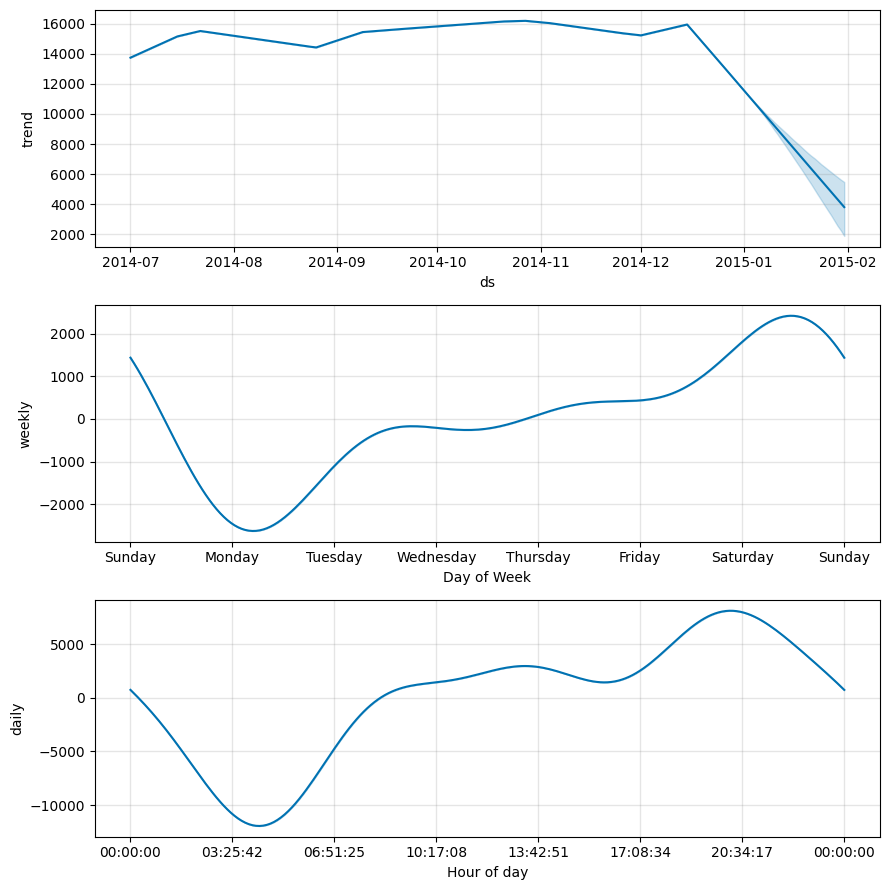

In [119]:
comp = m.plot_components(forecast)

# 